In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql import DataFrameStatFunctions as statFunc
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from pprint import pprint

In [2]:
# files = glob('/app/data/*/*.csv')
# files

In [3]:
conf = SparkConf().setMaster("spark://spark-master:7077")\
                  .setAppName('Test') \
                  .set('spark.driver.memory', '2g')\
                  .set('spark.executor.memory', '5g')

spark = SparkSession.builder\
                    .config(conf=conf)\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/07 12:24:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
schema = t.StructType([
    t.StructField('record_type', t.StringType()),
    t.StructField('type', t.StringType()),
    t.StructField('time', t.DoubleType()),
    t.StructField('project', t.StringType()),
    t.StructField('collector', t.StringType()),
    t.StructField('router', t.StringType()),
    t.StructField('router_ip', t.StringType()),
    t.StructField('peer_asn', t.IntegerType()),
    t.StructField('peer_address', t.StringType()),
    t.StructField('prefix', t.StringType()),
    t.StructField('next_hop', t.StringType()),
    t.StructField('as_path', t.StringType()),
    t.StructField('communities', t.StringType()),
])

df = spark.read.csv('/app/data/2024-07/1.csv', header=True, schema=schema)

In [5]:
df.show(10)

+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|record_type|type|               time|   project|       collector|router|router_ip|peer_asn|        peer_address|             prefix|            next_hop|             as_path|         communities|
+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:626b::/48|                NULL|                NULL|                NULL|
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:62c5::/48|                NULL|                NULL|                NULL|
|     update|  

In [6]:
start_time = dt.datetime(2024, 7, 7)
end_time = dt.datetime(2024, 7, 8)

start_unixtime = start_time.timestamp()
end_unixtime = end_time.timestamp()

In [7]:
df_period = df.filter((df.time >= start_unixtime) & (df.time < end_unixtime))

In [8]:
# Add time columns
df_enriched = df_period.withColumn('unixtime_second', f.col('time').cast(t.IntegerType()))\
                       .withColumn('datetime', f.from_unixtime('time'))\
                       .withColumn('hour', f.date_trunc('hour', 'datetime'))\
                       .withColumn('minute', f.date_trunc('minute', 'datetime'))

# Add origin
df_enriched = df_enriched.withColumn('as_path_split', f.split('as_path', ' '))\
                       .withColumn('as_path_unique', f.array_distinct('as_path_split'))\
                       .withColumn(
                           'origin_asn', f.get('as_path_unique', f.size('as_path_unique') - 1).cast(t.IntegerType())
                       )\
                      .withColumn('path_length', f.size('as_path_unique'))\
                      .drop('as_path_split')

# Add convergence periods by timeout
convergence_timeout = 300
peer_prefix_time_window = Window.partitionBy('peer_asn', 'prefix')\
                               .orderBy('time')
df_enriched = df_enriched.withColumn(
                            'peer_prefix_last_time', 
                            f.lag('time').over(peer_prefix_time_window)
                         )\
                         .withColumn(
                             'new_convergence_period', 
                             ((f.col('time') - f.col('peer_prefix_last_time')) > convergence_timeout).cast(t.IntegerType())
                         )\
                         .withColumn(
                             'convergence_period', 
                             f.sum('new_convergence_period').over(peer_prefix_time_window)
                         )

In [9]:
df_updates =  df_enriched.groupBy('hour', 'unixtime_second')\
                         .agg(f.count('time').alias('updates_1sec'))\
                         .groupBy('hour')\
                         .agg(
                            f.mean('updates_1sec').alias('mean_updates_1sec'),
                            f.std('updates_1sec').alias('std_updates_1sec'),
                            f.min('updates_1sec').alias('min_updates_1sec'),
                            f.percentile('updates_1sec', 0.25).alias('p25_updates_1sec'),
                            f.percentile('updates_1sec', 0.5).alias('median_updates_1sec'),
                            f.percentile('updates_1sec', 0.75).alias('p75_updates_1sec'),
                            f.max('updates_1sec').alias('max_updates_1sec')
                         )

In [10]:
df_paths_sec = df_enriched.groupBy('hour', 'unixtime_second')\
                             .agg(f.countDistinct('as_path_unique').alias('as_paths_1sec'))\
                             .groupBy('hour')\
                             .agg(
                                f.mean('as_paths_1sec').alias('mean_as_paths_1sec'),
                                f.std('as_paths_1sec').alias('std_as_paths_1sec'),
                                f.min('as_paths_1sec').alias('min_as_paths_1sec'),
                                f.percentile('as_paths_1sec', 0.25).alias('p25_as_paths_1sec'),
                                f.percentile('as_paths_1sec', 0.5).alias('median_as_paths_1sec'),
                                f.percentile('as_paths_1sec', 0.75).alias('p75_as_paths_1sec'),
                                f.max('as_paths_1sec').alias('max_as_paths_1sec')
                             )

# TODO: Time interpolation
# time_window = Window.orderBy('time')
# df_paths_prefix = df_enriched.groupBy('hour', 'unixtime_second', 'prefix')\
#                              .agg(
#                                  f.last('as_path_unique').over(time_window).alias('as_path_unique'),
#                                  f.last('path_length').over(time_window).alias('path_length')
#                              )\
#                              .groupBy('hour', 'unixtime_second')\
#                              .agg(
#                                 f.countDistinct('as_path_unique').alias('as_paths_1sec'),
#                                 f.mean('path_length').alias('mean_prefix_path_length')
#                              )\
#                              .groupBy('hour')\
#                              .agg()

df_paths =  df_enriched.groupBy('hour')\
                         .agg(
                            f.countDistinct('as_path_unique').alias('total_as_paths'),
                            f.mean('path_length').alias('mean_path_length'),
                            f.std('path_length').alias('std_path_length'),
                            f.min('path_length').alias('min_path_length'),
                            f.percentile('path_length', 0.25).alias('p25_path_length'),
                            f.percentile('path_length', 0.5).alias('median_path_length'),
                            f.percentile('path_length', 0.75).alias('p75_path_length'),
                            f.max('path_length').alias('max_path_length')
                         )\
                        .join(df_paths_sec, on='hour', how='left')

In [11]:
df_convergence = df_enriched.groupBy('hour', 'convergence_period')\
                            .agg((f.max('time') - f.min('time')).alias('convergence_time'))\
                            .groupBy('hour')\
                            .agg(
                                f.mean('convergence_time').alias('mean_convergence_time'),
                                f.std('convergence_time').alias('std_convergence_time'),
                                f.min('convergence_time').alias('min_convergence_time'),
                                f.percentile('convergence_time', 0.25).alias('p25_convergence_time'),
                                f.percentile('convergence_time', 0.5).alias('median_convergence_time'),
                                f.percentile('convergence_time', 0.75).alias('p75_convergence_time'),
                                f.max('convergence_time').alias('max_convergence_time')
                            )

In [12]:
df_hour = df_enriched.groupBy('hour')\
                     .agg(
                         f.countDistinct('peer_asn').alias('unique_peers'),
                         f.countDistinct('origin_asn').alias('unique_origins'),
                         f.countDistinct('prefix').alias('unique_prefixes'),
                         f.count('time').alias('updates')
                     )\
                    .join(df_updates, on='hour', how='left')\
                    .join(df_paths, on='hour', how='left')\
                    .join(df_convergence, on='hour', how='left')\
                    .sort(f.asc('hour'))

In [13]:
df_hour_pd = df_hour.toPandas()

25/04/07 12:25:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

In [14]:
# spark.stop()

In [15]:
os.makedirs('/app/data/results', exist_ok=True)
df_hour_pd.to_csv(f'/app/data/results/{start_time} - {end_time}', index=False)

In [16]:
df_hour_pd['hour'] = pd.to_datetime(df_hour_pd['hour'])
df_hour_pd

,hour,unique_peers,unique_origins,unique_prefixes,updates,mean_updates_1sec,std_updates_1sec,min_updates_1sec,p25_updates_1sec,median_updates_1sec,...,median_as_paths_1sec,p75_as_paths_1sec,max_as_paths_1sec,mean_convergence_time,std_convergence_time,min_convergence_time,p25_convergence_time,median_convergence_time,p75_convergence_time,max_convergence_time
0,2024-07-07 00:00:00,26,8134,49625,1378445,383.967967,502.365797,39,147.00,226.0,...,98.0,132.00,1301,2036.867371,1289.372261,1.478903,1346.753780,2119.050876,3077.080627,3599.726131
1,2024-07-07 01:00:00,27,18887,145475,1470129,408.369167,523.172082,38,148.00,234.5,...,103.0,144.00,1288,2425.227579,1535.476100,0.769950,1036.637155,3285.562339,3598.926214,3599.961592
2,2024-07-07 02:00:00,27,20421,130174,1786858,497.593428,596.562406,23,173.00,296.0,...,115.0,164.50,1573,2402.589409,1536.528214,1.325724,608.235415,3369.583061,3588.248012,3599.934501
3,2024-07-07 03:00:00,25,19969,159917,1994061,553.905833,623.901760,46,171.75,351.0,...,121.0,202.00,1518,2333.048244,1584.815078,0.404743,305.975298,3514.786097,3596.692822,3599.954235
4,2024-07-07 04:00:00,26,16033,97834,1428932,398.031198,491.934265,38,154.00,235.0,...,104.0,141.75,1492,2517.310632,1473.054016,0.411212,562.908898,3569.419112,3597.665992,3599.935102
5,2024-07-07 05:00:00,25,16385,83620,1418061,393.905833,526.385217,44,147.00,223.0,...,102.0,139.00,1354,2614.336668,1432.966368,0.413101,1541.087186,3575.994261,3596.322623,3599.947435
6,2024-07-07 06:00:00,26,15277,82100,1357187,378.046518,473.915437,42,145.00,223.0,...,101.0,142.00,1570,2712.989584,1397.778690,0.402023,1285.413178,3582.305021,3587.416907,3599.898129
7,2024-07-07 07:00:00,26,20780,148047,1579616,438.782222,511.501018,40,161.00,260.0,...,110.0,159.00,1335,2843.044984,1257.716340,0.618040,2828.989200,3572.760538,3598.024168,3599.934669
8,2024-07-07 08:00:00,25,7713,40224,1439638,401.013370,504.479365,29,147.00,234.0,...,100.0,141.00,1617,2899.851396,1192.178489,0.405955,2888.567085,3566.768792,3587.184902,3599.857392
9,2024-07-07 09:00:00,25,16151,97964,1419304,394.251111,513.748226,38,146.00,224.0,...,99.0,142.00,1344,2891.214118,1208.198323,0.506592,2925.104589,3544.544094,3597.684443,3599.937558


In [17]:
def plot_metrics_over_time(df: pd.DataFrame, 
                           time_col: str, 
                           figsize: tuple[int] = (15, 7),
                           ncols: int = 2) -> None:
    title = f'BGP Metrics over Time ({time_col.title()})'
    metrics = [col for col in df if col!=time_col]
    nrows = round(len(metrics) / ncols)
    fig, axs = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    fig.tight_layout() 
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    for i, metric in enumerate(metrics):
        row = i // ncols
        col = i % ncols
        df.plot(x='hour', y=metric, ax=axs[row,col])

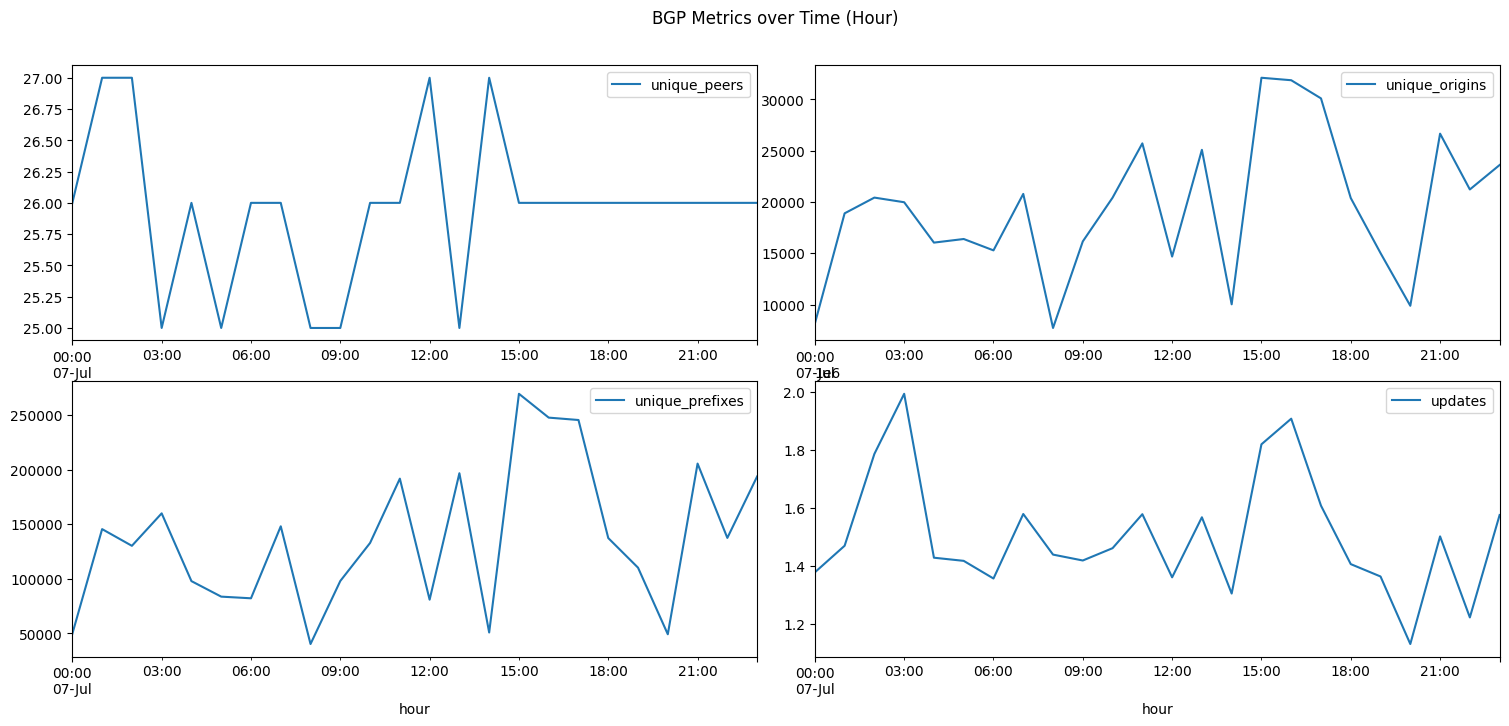

In [18]:
df_hour_ = df_hour_pd[['hour', 'unique_peers', 'unique_origins', 'unique_prefixes', 'updates']]
plot_metrics_over_time(df_hour_, 'hour', figsize=(15, 7))

<Axes: xlabel='hour'>

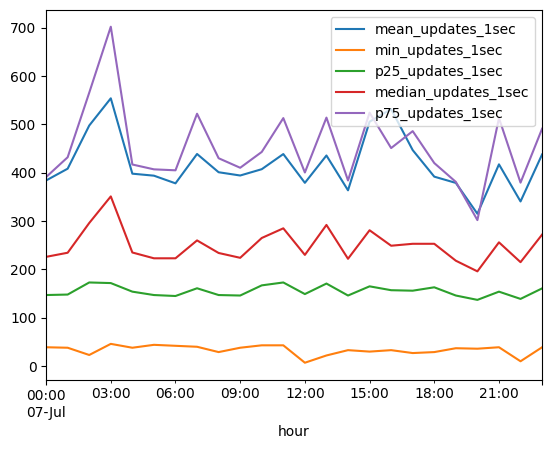

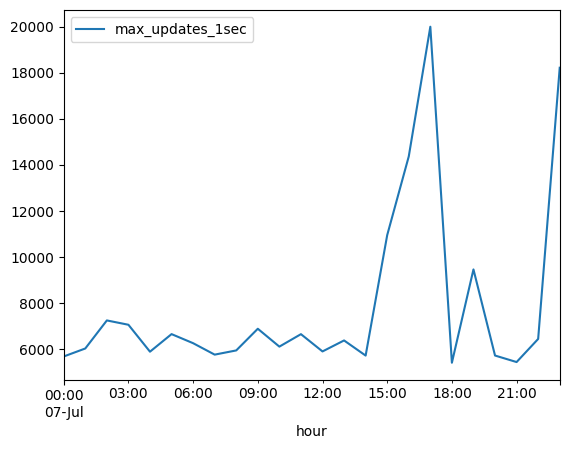

In [19]:
df_updates_ = df_hour_pd[['hour', 'mean_updates_1sec', 'min_updates_1sec', 'p25_updates_1sec', 'median_updates_1sec', 'p75_updates_1sec', 'max_updates_1sec']]
df_updates__ = df_updates_.drop(columns='max_updates_1sec')

ax = None
for col in df_updates__.columns:
    if col != 'hour':
        ax = df_updates__.plot(x='hour', y=col, ax=ax)
        
df_updates_.plot(x='hour', y='max_updates_1sec')

<Axes: xlabel='hour'>

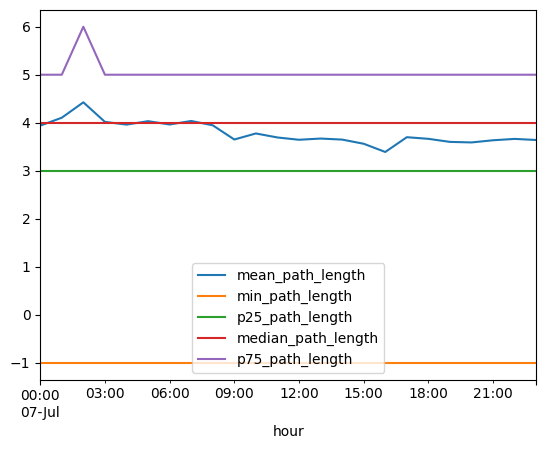

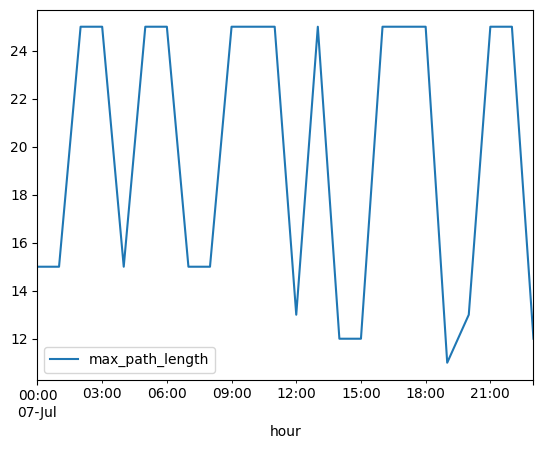

In [20]:
df_updates_ = df_hour_pd[['hour', 'mean_path_length', 'min_path_length', 'p25_path_length', 'median_path_length', 'p75_path_length', 'max_path_length']]
df_updates__ = df_updates_.drop(columns='max_path_length')

ax = None
for col in df_updates__.columns:
    if col != 'hour':
        ax = df_updates__.plot(x='hour', y=col, ax=ax)
        
df_updates_.plot(x='hour', y='max_path_length')

<Axes: xlabel='hour'>

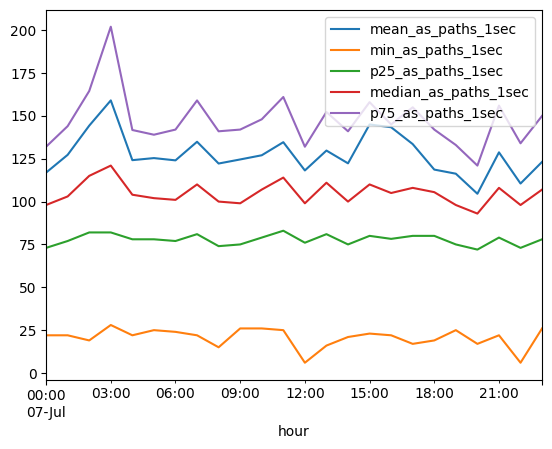

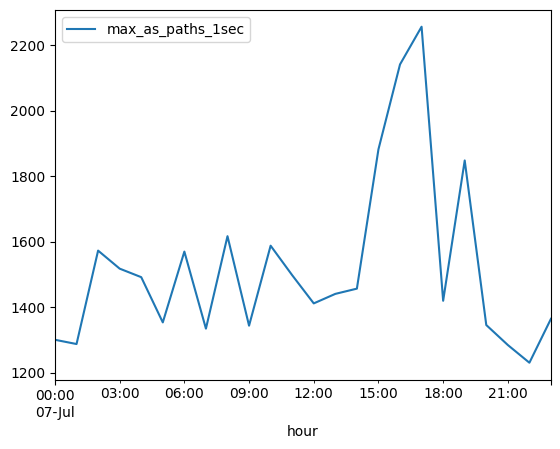

In [21]:
df_updates_ = df_hour_pd[['hour', 'mean_as_paths_1sec', 'min_as_paths_1sec', 'p25_as_paths_1sec', 'median_as_paths_1sec', 'p75_as_paths_1sec', 'max_as_paths_1sec']]
df_updates__ = df_updates_.drop(columns='max_as_paths_1sec')

ax = None
for col in df_updates__.columns:
    if col != 'hour':
        ax = df_updates__.plot(x='hour', y=col, ax=ax)
        
df_updates_.plot(x='hour', y='max_as_paths_1sec')

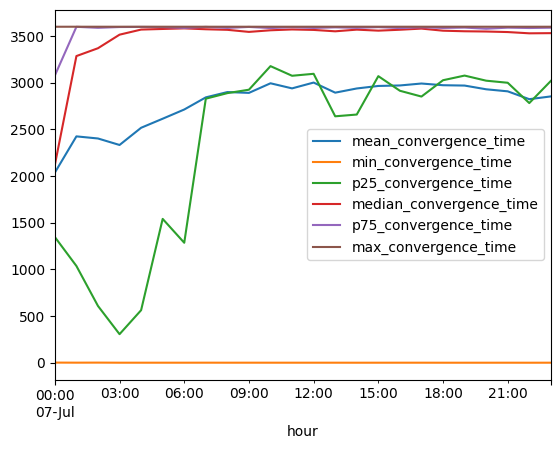

In [22]:
df_updates_ = df_hour_pd[['hour', 'mean_convergence_time', 'min_convergence_time', 'p25_convergence_time', 'median_convergence_time', 'p75_convergence_time', 'max_convergence_time']]
ax = None
for col in df_updates_:
    if col != 'hour':
        ax = df_updates_.plot(x='hour', y=col, ax=ax)